# 🚙 Прогнозирование цен на поддержанные автомобили в Великобритании

# 1. Подключение библиотек

In [109]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# инструмент для поиска лучших гиперпараметров
from sklearn.model_selection import GridSearchCV

#импортируем модели для их обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [110]:
audi_df = pd.read_csv("audi.csv")
ford_df = pd.read_csv("ford.csv")
bmw_df = pd.read_csv("bmw.csv")
toyota_df = pd.read_csv("toyota.csv")
cclass_df = pd.read_csv("cclass.csv")
focus_df = pd.read_csv("focus.csv")
merc_df = pd.read_csv("merc.csv")
skoda_df = pd.read_csv("skoda.csv")
vw_df = pd.read_csv("vw.csv")
hyundai_df = pd.read_csv("hyundi.csv")
opel_df = pd.read_csv("vauxhall.csv")


In [111]:
audi_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [112]:
bmw_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [113]:
ford_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


In [114]:
toyota_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


Почему то на платформе Kaggle скачались датасеты раздельно, поэтому сейчас объединим датасеты

In [115]:
toyota_df['brand'] = 'Toyota'
bmw_df['brand'] = 'BMW'
ford_df['brand'] = 'Ford'
audi_df['brand'] = 'Audi'
cclass_df['brand'] = 'Mercedes'
merc_df['brand'] = 'Mercedes'
focus_df['brand'] = 'Ford'
vw_df['brand'] = 'Volkswagen'
skoda_df['brand'] = 'Skoda'
hyundai_df['brand'] = 'Hyundai'
opel_df['brand'] = 'Opel'

In [116]:
toyota_df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0,Toyota
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0,Toyota
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0,Toyota
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0,Toyota
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0,Toyota


теперь объединим датасеты

In [117]:
df = pd.concat([audi_df, bmw_df, ford_df, toyota_df, merc_df, cclass_df, focus_df, skoda_df, vw_df, hyundai_df, opel_df], ignore_index=True)

In [118]:
df.sample(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,tax(£)
42851,Auris,2016,15475,Automatic,37298,Hybrid,0.0,70.6,1.8,Toyota,NaN
7236,A3,2015,18489,Semi-Auto,49748,Petrol,200.0,39.8,2.0,Audi,NaN
8492,A6,2014,13199,Manual,39562,Diesel,30.0,62.8,2.0,Audi,NaN
85975,Tiguan,2020,31290,Semi-Auto,2500,Diesel,145.0,31.4,2.0,Volkswagen,NaN
57635,B Class,2017,13299,Manual,15094,Diesel,145.0,68.9,1.5,Mercedes,NaN
84057,Polo,2017,11250,Manual,23534,Petrol,145.0,60.1,1.2,Volkswagen,NaN
28710,Ka+,2018,8500,Manual,7301,Petrol,145.0,57.7,1.2,Ford,NaN
3678,Q3,2019,37434,Semi-Auto,7841,Petrol,150.0,31.7,2.0,Audi,NaN
99121,Astra,2017,9699,Manual,35507,Diesel,145.0,72.4,1.6,Opel,NaN
94919,Corsa,2013,4350,Manual,52243,Petrol,125.0,51.4,1.2,Opel,NaN


In [119]:
# Красоту наводим
new_order = ['brand'] + [col for col in df.columns if col not in ['brand', 'price']] + ['price']
df = df[new_order]

In [120]:
df.sample(10)

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
65953,Ford,Focus,2017,Semi-Auto,39900,Diesel,NaN,NaN,1.5,NaN,9890
33619,Ford,EcoSport,2018,Manual,10000,Petrol,145.0,54.3,1.0,NaN,15490
96121,Opel,Corsa,2019,Manual,12959,Petrol,145.0,43.5,1.4,NaN,12420
80723,Volkswagen,Passat,2015,Semi-Auto,27200,Diesel,30.0,62.8,2.0,NaN,13995
57211,Mercedes,A Class,2018,Automatic,3545,Diesel,145.0,68.9,2.1,NaN,20250
42920,Toyota,Auris,2018,Automatic,65601,Hybrid,135.0,68.8,1.8,NaN,15450
61902,Mercedes,C Class,2019,Semi-Auto,8059,Petrol,NaN,NaN,1.5,NaN,26299
7185,Audi,Q2,2019,Manual,3902,Petrol,145.0,43.5,1.5,NaN,22800
47011,Mercedes,CL Class,2014,Semi-Auto,35677,Diesel,30.0,62.8,2.1,NaN,13495
85249,Volkswagen,Tiguan,2019,Semi-Auto,2936,Diesel,145.0,39.8,2.0,NaN,26998


## Описание данных

- brand — марка (Ford, BMW, Audi и др.)
- model — модель (Focus, Q5, 3 Series и др.)
- year — год выпуска
- transmission — коробка передач (Manual, Automatic, Semi-Auto)
- mileage — пробег в милях
- fuelType — тип топлива (Petrol, Diesel, Hybrid, Electric)
- tax — дорожный налог в £/год
- mpg — расход топлива (мили на галлон)
- engineSize — объём двигателя в литрах
- price — цена в £

In [121]:
df.shape

(108540, 11)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           94327 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   tax(£)        4860 non-null    float64
 10  price         108540 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 9.1+ MB


Изучив краткую информацию о датасете, приходим к выводу, что пропусков нет, отлично!

In [123]:
df = df.drop_duplicates()
df.shape

(106267, 11)

In [124]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,106267.0,2017.072497,2.132114,1970.0,2016.0,2017.0,2019.0,2060.0
mileage,106267.0,23219.477919,21126.685272,1.0,7724.0,17515.0,32449.0,323000.0
tax,92938.0,120.088715,63.613732,0.0,125.0,145.0,145.0,580.0
mpg,97712.0,55.205623,16.181659,0.3,47.1,54.3,62.8,470.8
engineSize,106267.0,1.664939,0.558165,0.0,1.2,1.6,2.0,6.6
tax(£),4774.0,121.187683,58.135472,0.0,125.0,145.0,145.0,555.0
price,106267.0,16863.020787,9780.077771,450.0,10190.0,14578.0,20882.0,159999.0


Вижу некую аномалию в поле year и price, проверим эти строки и исправим это

In [125]:
df[df['year'] >= 2020]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
198,Audi,Q7,2020,Semi-Auto,10,Diesel,145.0,33.2,3.0,NaN,62985
220,Audi,Q5,2020,Semi-Auto,10,Petrol,145.0,32.1,2.0,NaN,37985
223,Audi,Q5,2020,Semi-Auto,10,Petrol,145.0,30.7,2.0,NaN,47895
224,Audi,A4,2020,Semi-Auto,10,Petrol,145.0,42.2,2.0,NaN,31985
316,Audi,Q7,2020,Semi-Auto,826,Diesel,145.0,29.4,4.0,NaN,82995
...,...,...,...,...,...,...,...,...,...,...,...
108386,Opel,Combo Life,2020,Manual,10,Diesel,145.0,50.4,1.5,NaN,21295
108387,Opel,Combo Life,2020,Manual,346,Petrol,145.0,42.2,1.2,NaN,16390
108438,Opel,Combo Life,2020,Semi-Auto,1950,Petrol,145.0,40.4,1.2,NaN,24995
108440,Opel,Combo Life,2020,Semi-Auto,500,Petrol,145.0,40.4,1.2,NaN,21490


In [126]:
df[df['price'] > 90000]  

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
1646,Audi,R8,2019,Semi-Auto,4000,Petrol,145.0,21.4,5.2,NaN,129000
2255,Audi,R8,2020,Semi-Auto,70,Petrol,145.0,21.1,5.2,NaN,137995
3359,Audi,R8,2019,Automatic,100,Petrol,145.0,24.1,5.2,NaN,125000
3367,Audi,R8,2019,Automatic,1000,Petrol,145.0,32.8,5.2,NaN,135000
3711,Audi,RS6,2020,Semi-Auto,3220,Petrol,150.0,22.1,4.0,NaN,97500
...,...,...,...,...,...,...,...,...,...,...,...
56433,Mercedes,A Class,2019,Automatic,163,Petrol,145.0,30.1,4.0,NaN,97900
56959,Mercedes,A Class,2018,Automatic,9141,Petrol,145.0,24.8,4.0,NaN,90900
59212,Mercedes,A Class,2017,Automatic,1755,Petrol,145.0,24.8,4.0,NaN,109495
73617,Skoda,Karoq,2019,Automatic,3764,Petrol,145.0,40.9,1.5,NaN,91874


Посмотрели на эти значения, все таки значения правильные, но строчку с аномальным годом все же удалим
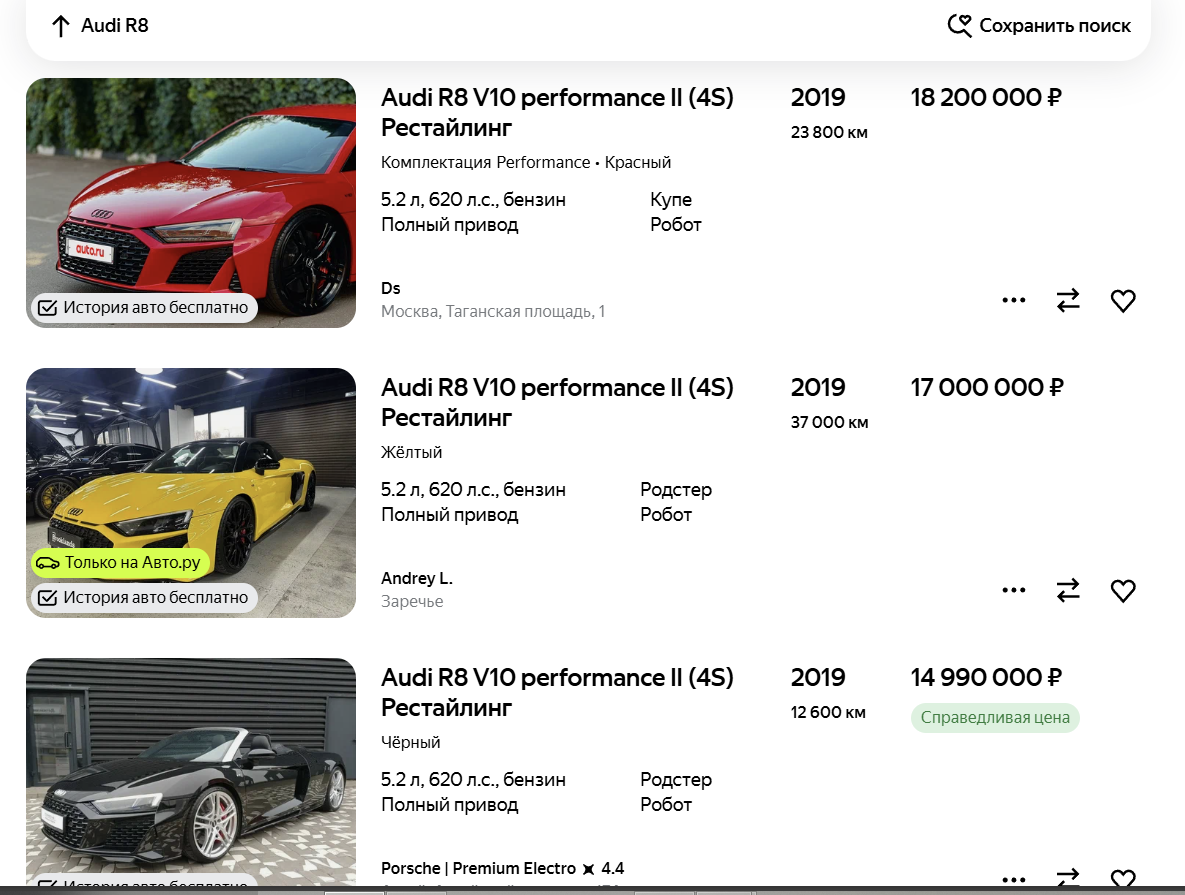

In [127]:
df = df[df['year'] <= 2020]

In [128]:
df[df['engineSize'] == 0]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
7505,Audi,Q5,2019,Automatic,5886,Petrol,135.0,117.7,0.0,NaN,44790
7506,Audi,Q3,2019,Automatic,1500,Diesel,145.0,47.1,0.0,NaN,32788
7516,Audi,Q3,2020,Manual,1500,Petrol,145.0,40.9,0.0,NaN,29944
7517,Audi,Q3,2020,Automatic,1500,Diesel,145.0,47.1,0.0,NaN,33333
7518,Audi,Q3,2020,Automatic,1500,Petrol,145.0,32.5,0.0,NaN,29944
...,...,...,...,...,...,...,...,...,...,...,...
108012,Opel,Insignia,2018,Manual,17733,Petrol,145.0,46.3,0.0,NaN,15500
108014,Opel,Insignia,2018,Manual,9633,Petrol,150.0,42.8,0.0,NaN,17000
108020,Opel,Insignia,2017,Manual,30740,Diesel,150.0,65.7,0.0,NaN,11500
108223,Opel,Ampera,2014,Automatic,50486,Hybrid,0.0,235.4,0.0,NaN,10495


Группируем по бренду и модели, заполняем медианой


In [129]:
df['engineSize'] = df['engineSize'].replace(0, np.nan)
df['engineSize'] = df.groupby(['brand', 'model'])['engineSize'].transform(
    lambda x: x.fillna(x.median())
)

In [130]:
df['tax'] = df.groupby(['fuelType', 'engineSize'])['tax'].transform(
    lambda x: x.fillna(x.median())
)

df['tax'] = df['tax'].fillna(df['tax'].median())

In [131]:
df['mpg'] = df.groupby(['fuelType', 'engineSize'])['mpg'].transform(
    lambda x: x.fillna(x.median())
)

df['mpg'] = df['mpg'].fillna(df['mpg'].median())

In [132]:
df = df[df['engineSize'] > 0]

In [133]:
df[df['mileage'] > 300000]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
9822,Audi,A6,2008,Manual,323000,Diesel,200.0,44.1,2.0,NaN,2490


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106265 entries, 0 to 108539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         106265 non-null  object 
 1   model         106265 non-null  object 
 2   year          106265 non-null  int64  
 3   transmission  106265 non-null  object 
 4   mileage       106265 non-null  int64  
 5   fuelType      106265 non-null  object 
 6   tax           106265 non-null  float64
 7   mpg           106265 non-null  float64
 8   engineSize    106265 non-null  float64
 9   tax(£)        4774 non-null    float64
 10  price         106265 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 9.7+ MB


In [135]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,106265.0,2017.072187,2.127839,1970.0,2016.0,2017.0,2019.0,2020.0
mileage,106265.0,23218.514591,21125.546029,1.0,7724.0,17515.0,32448.0,323000.0
tax,106265.0,122.107561,61.048398,0.0,125.0,145.0,145.0,580.0
mpg,106265.0,55.397607,15.961832,0.3,47.1,55.4,62.8,470.8
engineSize,106265.0,1.668747,0.552319,0.6,1.2,1.6,2.0,6.6
tax(£),4774.0,121.187683,58.135472,0.0,125.0,145.0,145.0,555.0
price,106265.0,16863.234696,9780.044553,450.0,10190.0,14579.0,20882.0,159999.0


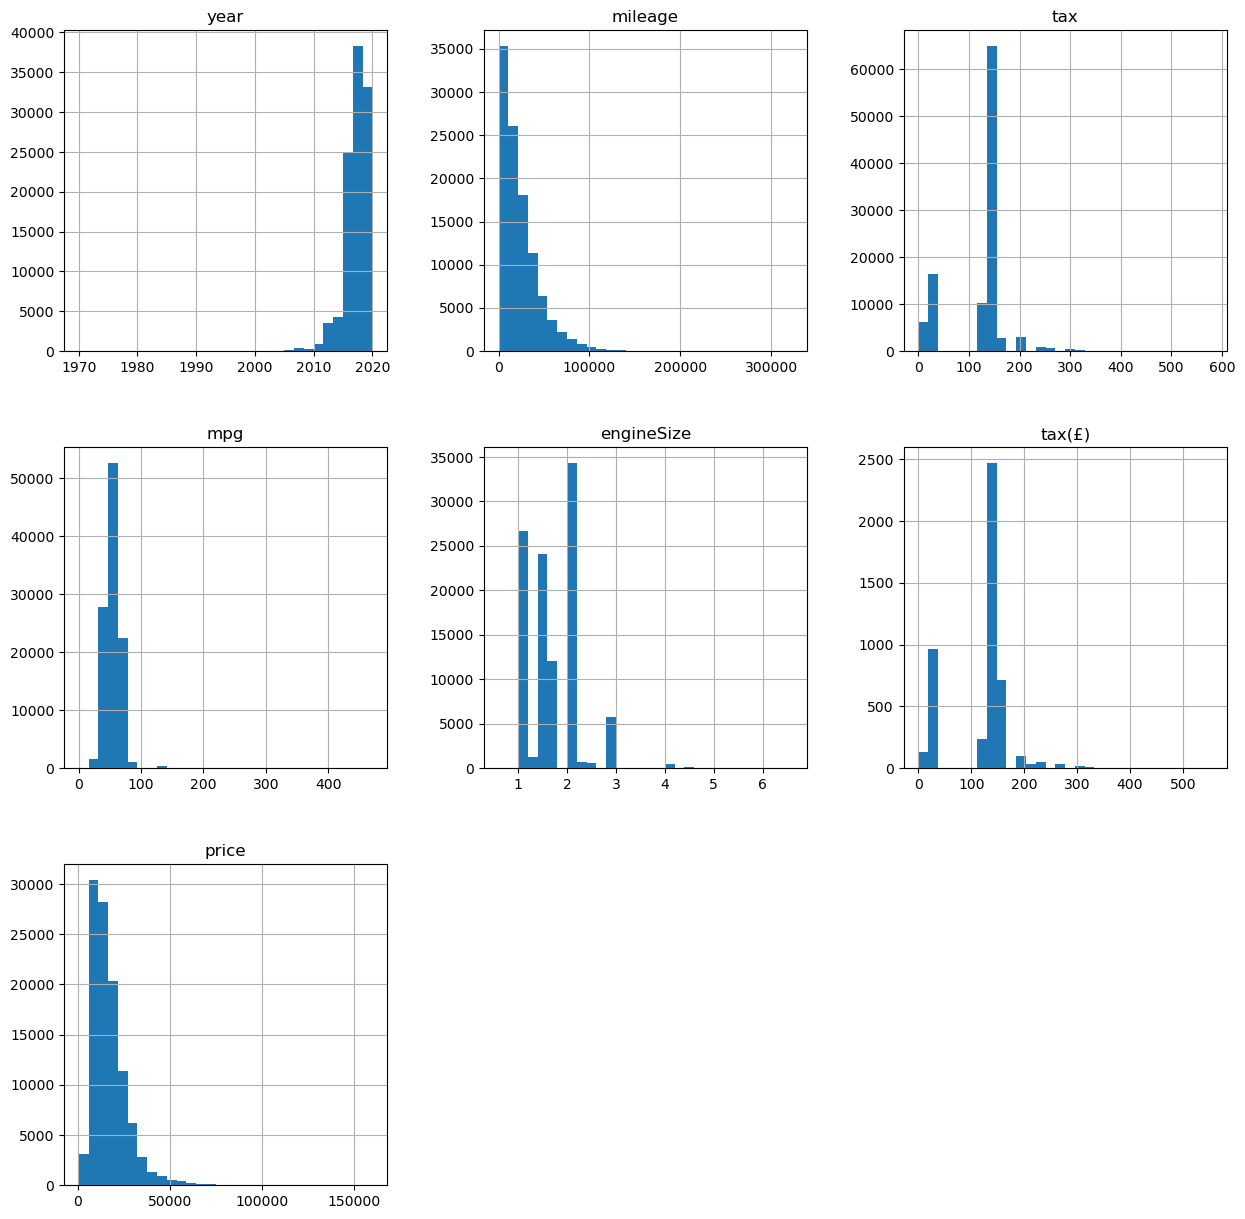

In [136]:
df.hist(figsize = (15,15), bins = 30);

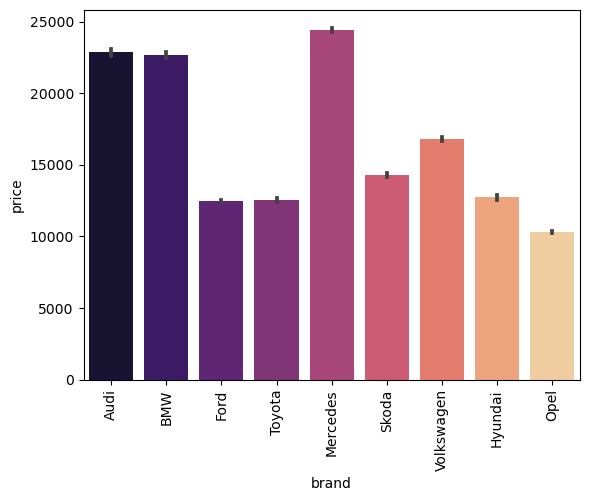

In [137]:
# Визуализируем цены автомобилей от брендов
sns.barplot(data = df, x = 'brand', y = 'price', palette = 'magma')
plt.xticks(rotation = 'vertical')
plt.show()

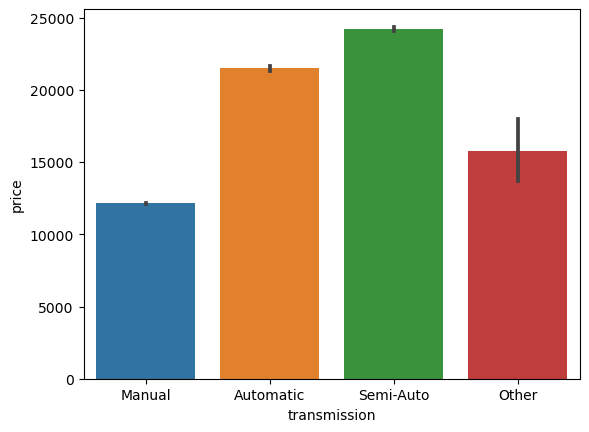

In [138]:
sns.barplot(data = df, x = 'transmission', y = 'price')
plt.show()

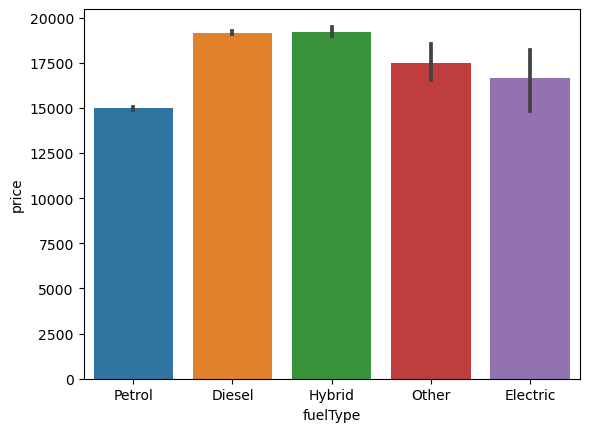

In [139]:
sns.barplot(data = df, x = 'fuelType', y = 'price')
plt.show()

In [140]:
df.sample(5)

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
43845,Toyota,Aygo,2017,Manual,11367,Petrol,145.0,68.9,1.0,NaN,8432
41848,Toyota,Yaris,2017,Manual,19540,Petrol,145.0,58.9,1.5,NaN,8940
105401,Opel,Zafira,2018,Manual,15866,Petrol,145.0,41.5,1.4,NaN,12190
28795,Ford,Fiesta,2018,Manual,19500,Petrol,150.0,65.7,1.0,NaN,10290
73196,Skoda,Yeti Outdoor,2017,Manual,30644,Diesel,145.0,62.8,2.0,NaN,13199


In [141]:
df.columns

Index(['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'tax(£)', 'price'],
      dtype='object')

In [142]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [143]:
df['brand_encode'] = le.fit_transform(df['brand'])
df['model_encode'] = le.fit_transform(df['model'])
df['transmission_encode'] = le.fit_transform(df['transmission'])
df['fuelType_encode'] = le.fit_transform(df['fuelType'])

In [144]:
fit_df = df[['brand_encode',
            'model_encode',
            'year',
            'transmission_encode',
            'mileage',
            'fuelType_encode',
            'tax',
            'mpg',
            'engineSize',
            'price'
           ]]

<Axes: >

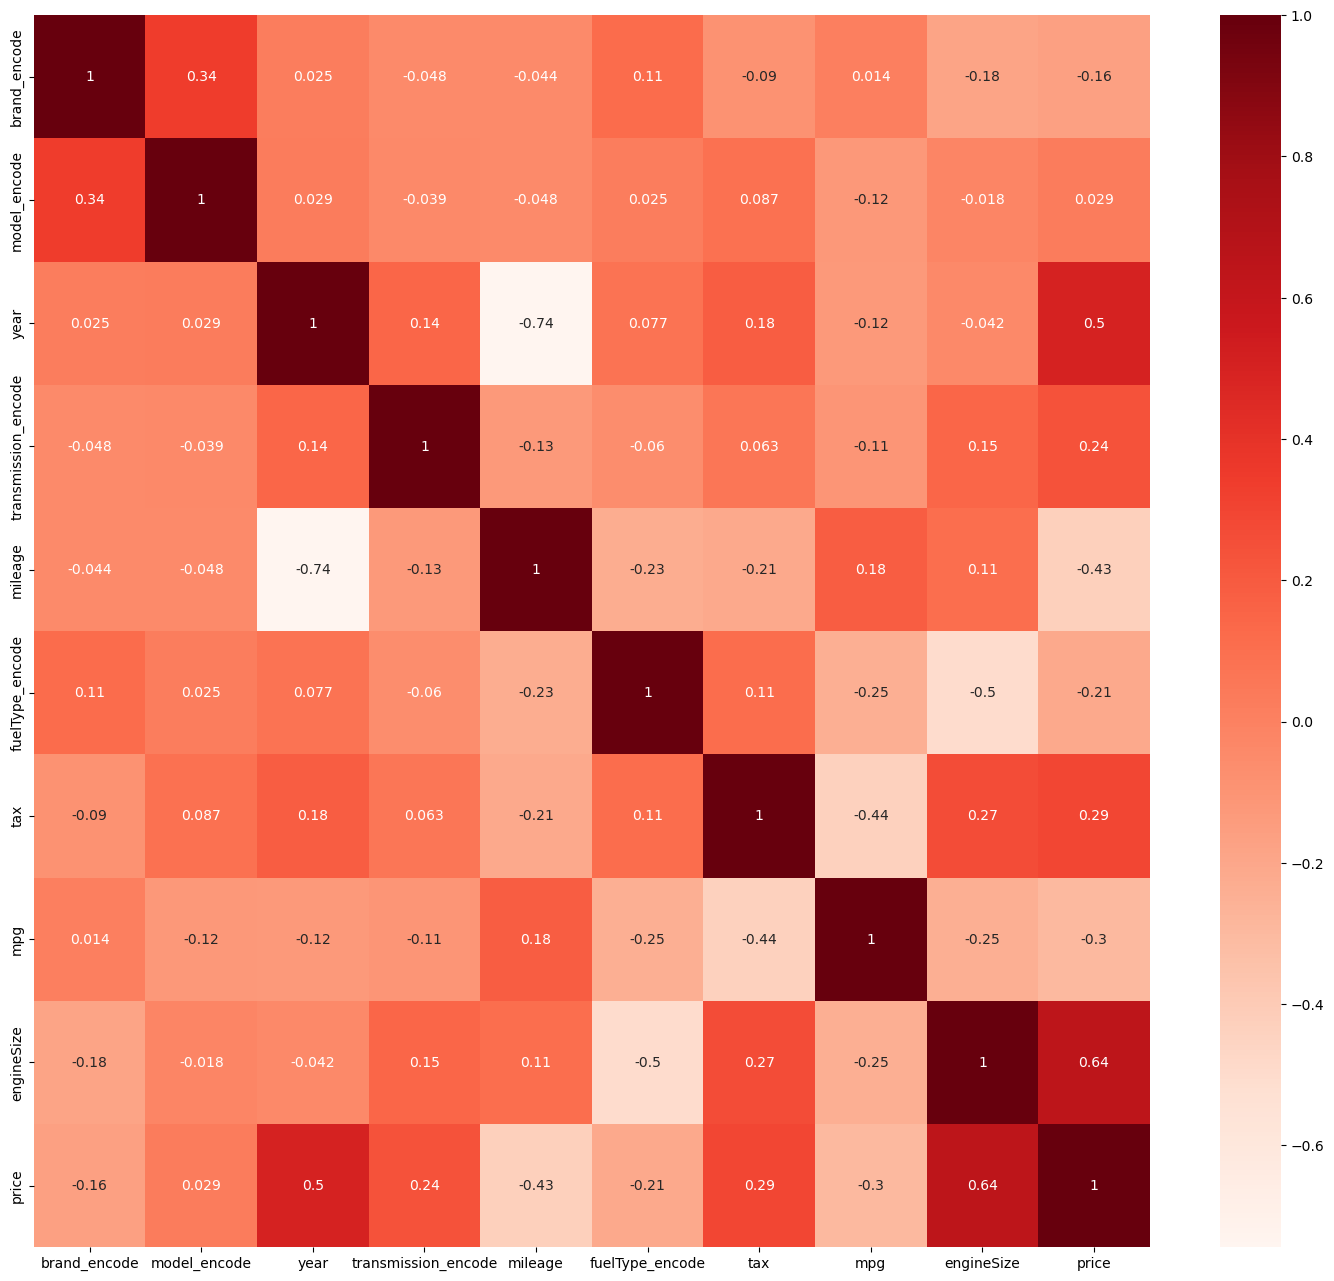

In [145]:
plt.figure(figsize=(18, 16))
sns.heatmap(fit_df.corr(), annot=True, cmap='Reds')

# 3. Обучение моделей

In [146]:
fit_df.head()

,brand_encode,model_encode,year,transmission_encode,mileage,fuelType_encode,tax,mpg,engineSize,price
0,0,9,2017,1,15735,4,150.0,55.4,1.4,12500
1,0,14,2016,0,36203,0,20.0,64.2,2.0,16500
2,0,9,2016,1,29946,4,30.0,55.4,1.4,11000
3,0,12,2017,0,25952,0,145.0,67.3,2.0,16800
4,0,11,2019,1,1998,4,145.0,49.6,1.0,17300


In [147]:
X = fit_df.drop(['price'], axis=1)
y = fit_df['price']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [149]:
from sklearn.linear_model import LinearRegression

In [150]:
lrm = LinearRegression()
lrm.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [151]:
predictions = lrm.predict(X_test_scaled)
predictions

array([[-0.59997309],
       [-0.5664208 ],
       [ 0.09131491],
       ...,
       [ 0.34521247],
       [ 2.28212769],
       [-0.34037048]])

<Axes: >

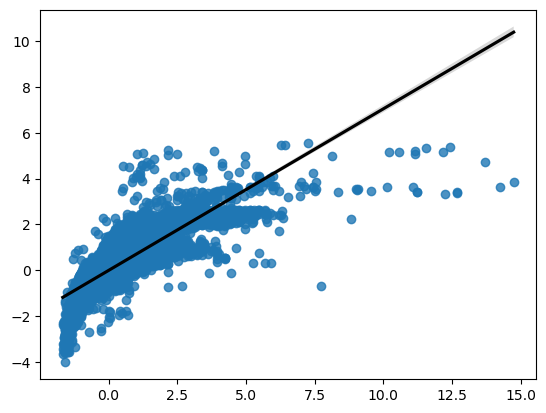

In [152]:
sns.regplot(x=y_test_scaled, y=predictions, line_kws={"color":"black"})

In [153]:
metrics.r2_score(y_test_scaled, predictions)

0.7184586261925191

## Нейросеть Keras

In [154]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

In [164]:
model = models.Sequential([
    layers.Input(shape=(9,)),
    
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),    
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

In [165]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               1280      
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 8)                 136       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289

In [166]:
# Колбэк на ранюю остановку при малом изменении функции потерь
early_stop = EarlyStopping(monitor='val_loss', patience=10)
callbacks = [early_stop]

# Обучение
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.1541 - mae: 0.2499 - val_loss: 0.1370 - val_mae: 0.2163
Epoch 2/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.1136 - mae: 0.2110 - val_loss: 0.1275 - val_mae: 0.2057
Epoch 3/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.1030 - mae: 0.1983 - val_loss: 0.1137 - val_mae: 0.1917
Epoch 4/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0978 - mae: 0.1913 - val_loss: 0.1123 - val_mae: 0.1867
Epoch 5/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0909 - mae: 0.1838 - val_loss: 0.1106 - val_mae: 0.1852
Epoch 6/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0877 - mae: 0.1797 - val_loss: 0.0990 - val_mae: 0.1772
Epoch 7/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0855 - mae: 0.1771 - val_loss: 0.1004 - val_mae: 0.1733
Epoch 8/200
2325/2325 [==============================] 

2325/2325 [==============================] - 3s 1ms/step - loss: 0.0477 - mae: 0.1388 - val_loss: 0.0698 - val_mae: 0.1542
Epoch 62/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0478 - mae: 0.1385 - val_loss: 0.0656 - val_mae: 0.1455
Epoch 63/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0475 - mae: 0.1385 - val_loss: 0.0672 - val_mae: 0.1438
Epoch 64/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0475 - mae: 0.1381 - val_loss: 0.0672 - val_mae: 0.1430
Epoch 65/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0476 - mae: 0.1383 - val_loss: 0.0668 - val_mae: 0.1455
Epoch 66/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0467 - mae: 0.1374 - val_loss: 0.0632 - val_mae: 0.1427
Epoch 67/200
2325/2325 [==============================] - 3s 1ms/step - loss: 0.0476 - mae: 0.1378 - val_loss: 0.0668 - val_mae: 0.1456
Epoch 68/200
2325/2325 [==============================] - 3s 

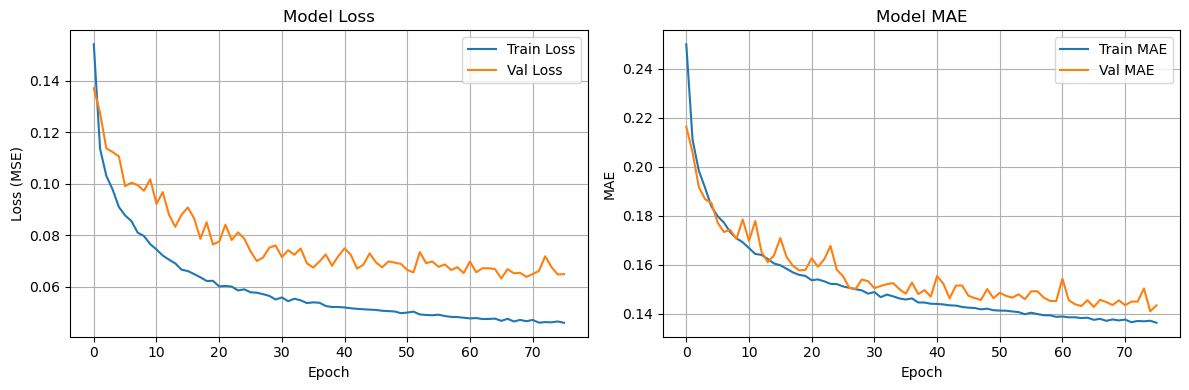

In [167]:
# Визуализация обучения
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train MAE')
    axes[1].plot(history.history['val_mae'], label='Val MAE')
    axes[1].set_title('Model MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [168]:
# Предсказания
y_pred_scaled = model.predict(X_test_scaled).flatten()

# Обратное преобразование масштаба
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

997/997 [==============================] - 1s 640us/step


<Axes: >

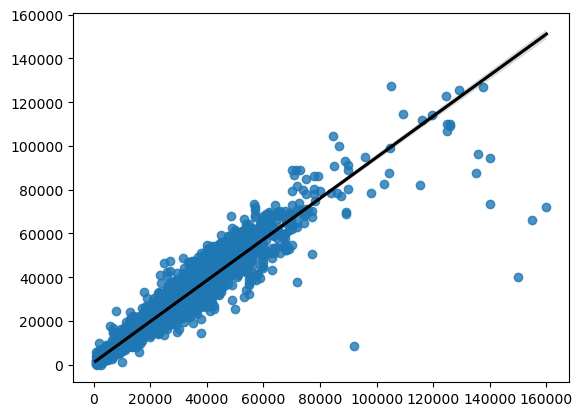

In [169]:
sns.regplot(x=y_test_original, y=y_pred, line_kws={"color":"black"})

In [170]:
metrics.r2_score(y_test_original, y_pred)

0.9382361121152316

In [171]:
metrics.mean_absolute_error(y_test_original, y_pred)

1391.3667968906752

# Заключение
Нейронная модель обучилась лучше чем линейная регрессия, это успех!!